# 0. **Title: Facial Expression Classification with AffectNet & MobileNetV2**

# 1. **Imports & Environment Setup**

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Multiply, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

print("All libraries imported ✅")
print("TensorFlow version:", tf.__version__)


# 2. **Hyperparameters**

In [ ]:
IMG_SIZE   = 160
BATCH_SIZE = 32
EPOCHS_1   = 10
EPOCHS_2   = 25
SMOOTHING  = 0.1

# 3. **Data Loading: AffectNet CSV and Paths**


In [ ]:
# Path to AffectNet CSV and image directory
csv_path = "/Users/mac/Desktop/Affectnet/labels.csv"
base_dir = "/Users/mac/Desktop/Affectnet"

# Load the dataframe with image paths and labels
df = pd.read_csv(csv_path)
print("DataFrame loaded. Shape:", df.shape)
display(df.head())

# 4. **Pre-processing & Helper Functions**

## 4.1. **Load Images and Labels**

In [9]:
def load_affectnet(df_subset, base_dir):
    """Load images and their labels from AffectNet based on a DataFrame subset."""
    imgs, labs = [], []
    for _, row in df_subset.iterrows():
        rel_path, label = row['pth'], row['label']
        candidates = [
            os.path.join(base_dir, 'Train', rel_path),
            os.path.join(base_dir, 'Test', rel_path)
        ]
        candidates += [p[:-4] + ('.jpg' if p.endswith('.png') else '.png') for p in candidates]
        path = next((p for p in candidates if os.path.exists(p)), None)
        if path:
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            imgs.append(img)
            labs.append(label)
    return np.array(imgs, dtype='float32'), np.array(labs)


## 4.2. **Split Train/Test and Load Data**

In [11]:
is_train = df['pth'].apply(lambda x: os.path.exists(os.path.join(base_dir, 'Train', x)))
is_test  = df['pth'].apply(lambda x: os.path.exists(os.path.join(base_dir, 'Test', x)))

X_train, y_train = load_affectnet(df[is_train], base_dir)
X_test,  y_test  = load_affectnet(df[is_test], base_dir)

print(f"Loaded images: X_train {X_train.shape}, X_test {X_test.shape}")


Loaded images: X_train (15579, 160, 160, 3), X_test (14093, 160, 160, 3)


## 4.3. **Label Encoding and Preprocessing**

In [13]:
# Encode string labels as integers
le = LabelEncoder()
le.fit(np.concatenate([y_train, y_test]))
y_tr_enc = le.transform(y_train)
y_te_enc = le.transform(y_test)
num_classes = len(le.classes_)

# Compute class weights
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_tr_enc), y=y_tr_enc)
class_w = dict(enumerate(cw))

# MobileNetV2 preprocessing
X_train = preprocess_input(X_train)
X_test  = preprocess_input(X_test)

# One-hot encode labels
y_tr_cat = tf.keras.utils.to_categorical(y_tr_enc, num_classes)
y_te_cat = tf.keras.utils.to_categorical(y_te_enc, num_classes)


# 5. **Data Visualization**

## 5.1. **Class Distribution**

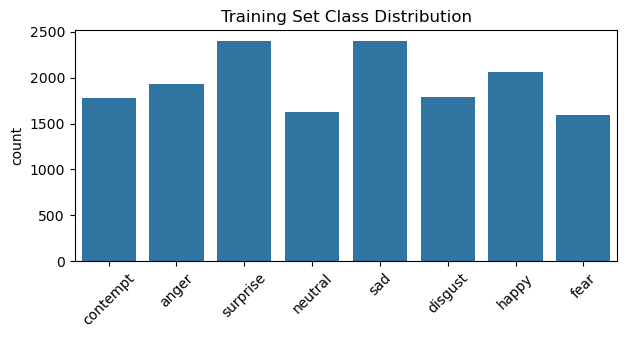

In [15]:
plt.figure(figsize=(7,3))
sns.countplot(x=y_train)
plt.title('Training Set Class Distribution')
plt.xticks(rotation=45)
plt.show()


## 5.2. **Display a Random Sample Image**

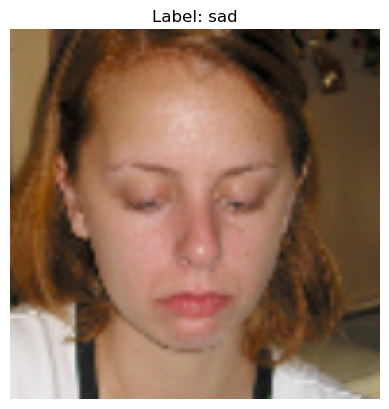

In [17]:
rand_idx = np.random.randint(len(X_train))
plt.imshow((X_train[rand_idx] + 1) / 2)  # Deprocess for display
plt.title(f"Label: {le.inverse_transform([y_tr_enc[rand_idx]])[0]}")
plt.axis('off')
plt.show()


# 6. **Data Augmentation**

In [19]:
#generate new training images by randomly transforming your existing images.

aug = ImageDataGenerator(
    preprocessing_function=lambda x: tf.image.random_contrast(x, .8, 1.4),
    rotation_range=40,
    width_shift_range=.25,
    height_shift_range=.25,
    zoom_range=.3,
    horizontal_flip=True,
    brightness_range=[.6, 1.4],
    shear_range=.3
)
aug.fit(X_train)

# 7. **Model Definition: MobileNetV2 + Squeeze-and-Excite**

In [21]:
def squeeze_excite_block(x, ratio=8):
    """Squeeze-and-Excite block for channel-wise attention."""
    init, channels = x, x.shape[-1]
    se = GlobalAveragePooling2D()(x)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = Reshape((1, 1, channels))(se)
    return Multiply()([init, se])

base = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base.trainable = False

x = squeeze_excite_block(base.output)
x = GlobalAveragePooling2D()(x)
x = Dense(384, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base.input, outputs=out)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=SMOOTHING),
    metrics=['accuracy']
)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[0][0]']        

# 8. **Callbacks**

In [23]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)


# 9. **Model Training (Phase 1: Frozen Base)**

In [25]:
hist1 = model.fit(
    aug.flow(X_train, y_tr_cat, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS_1,
    validation_data=(X_test, y_te_cat),
    class_weight=class_w,
    callbacks=[lr_scheduler, early_stopping]
)


Epoch 1/10
486/486 [==============================] - 87s 178ms/step - loss: 1.9724 - accuracy: 0.2457 - val_loss: 1.8711 - val_accuracy: 0.3235 - lr: 0.0010
Epoch 2/10
486/486 [==============================] - 94s 193ms/step - loss: 1.8980 - accuracy: 0.2902 - val_loss: 1.8810 - val_accuracy: 0.3116 - lr: 0.0010
Epoch 3/10
486/486 [==============================] - 84s 173ms/step - loss: 1.8641 - accuracy: 0.3113 - val_loss: 1.8410 - val_accuracy: 0.3259 - lr: 0.0010
Epoch 4/10
486/486 [==============================] - 81s 167ms/step - loss: 1.8438 - accuracy: 0.3178 - val_loss: 1.8006 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 5/10
486/486 [==============================] - 81s 167ms/step - loss: 1.8360 - accuracy: 0.3273 - val_loss: 1.8298 - val_accuracy: 0.3426 - lr: 0.0010
Epoch 6/10
486/486 [==============================] - 80s 165ms/step - loss: 1.8237 - accuracy: 0.3295 - val_loss: 1.8311 - val_accuracy: 0.3457 - lr: 0.0010
Epoch 7/10
486/486 [==============================] 

# 10. **Fine-Tuning Top 60 Layers (Phase 2)**

In [27]:
base.trainable = True
for layer in base.layers[:-60]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=SMOOTHING),
    metrics=['accuracy']
)

hist2 = model.fit(
    aug.flow(X_train, y_tr_cat, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS_2,
    validation_data=(X_test, y_te_cat),
    class_weight=class_w,
    callbacks=[lr_scheduler, early_stopping]
)


Epoch 1/25
486/486 [==============================] - 115s 234ms/step - loss: 1.7450 - accuracy: 0.3776 - val_loss: 1.6728 - val_accuracy: 0.4416 - lr: 1.0000e-04
Epoch 2/25
486/486 [==============================] - 96s 197ms/step - loss: 1.5683 - accuracy: 0.4708 - val_loss: 1.7784 - val_accuracy: 0.4308 - lr: 1.0000e-04
Epoch 3/25
486/486 [==============================] - 137s 283ms/step - loss: 1.4893 - accuracy: 0.5144 - val_loss: 1.3899 - val_accuracy: 0.5696 - lr: 1.0000e-04
Epoch 4/25
486/486 [==============================] - 108s 222ms/step - loss: 1.4339 - accuracy: 0.5449 - val_loss: 1.3752 - val_accuracy: 0.5726 - lr: 1.0000e-04
Epoch 5/25
486/486 [==============================] - 91s 188ms/step - loss: 1.3808 - accuracy: 0.5714 - val_loss: 1.3159 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 6/25
486/486 [==============================] - 92s 189ms/step - loss: 1.3520 - accuracy: 0.5847 - val_loss: 1.3014 - val_accuracy: 0.6047 - lr: 1.0000e-04
Epoch 7/25
486/486 [=====

# 11. **Plot Accuracy and Loss Curves**

# 12. **Evaluation: Metrics and Confusion Matrix**

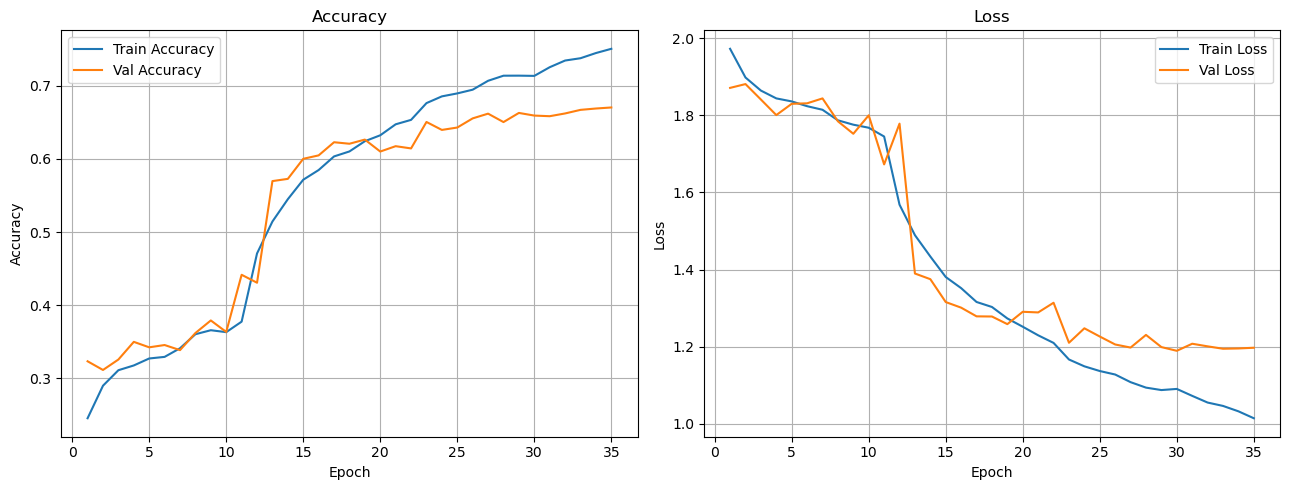

In [29]:
def plot_training_curves(hist1, hist2):
    acc = hist1.history['accuracy'] + hist2.history['accuracy']
    val_acc = hist1.history['val_accuracy'] + hist2.history['val_accuracy']
    loss = hist1.history['loss'] + hist2.history['loss']
    val_loss = hist1.history['val_loss'] + hist2.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(13,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.legend(); plt.title('Accuracy'); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.title('Loss'); plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_curves(hist1, hist2)



Final Test Accuracy: 0.670
              precision    recall  f1-score   support

       anger       0.65      0.67      0.66      1815
    contempt       0.66      0.65      0.66      1511
     disgust       0.68      0.51      0.58      1778
        fear       0.64      0.66      0.65      1552
       happy       0.85      0.85      0.85      2281
     neutral       0.49      0.64      0.56      1378
         sad       0.61      0.71      0.66      1500
    surprise       0.71      0.63      0.67      2278

    accuracy                           0.67     14093
   macro avg       0.66      0.67      0.66     14093
weighted avg       0.68      0.67      0.67     14093



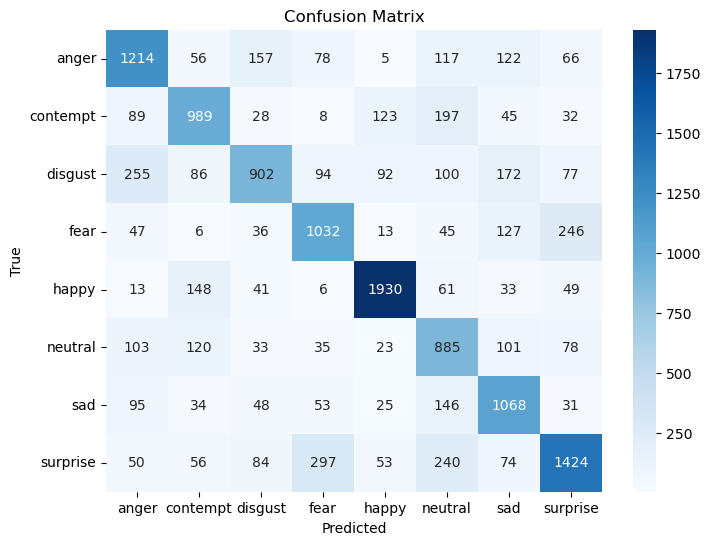

In [31]:
loss, acc = model.evaluate(X_test, y_te_cat, verbose=0)
print(f"\nFinal Test Accuracy: {acc:.3f}")

y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
print(classification_report(y_te_enc, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_te_enc, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# 13. **Show 10 Validation Samples with Predictions**

1/1 [==============================] - 0s 46ms/step


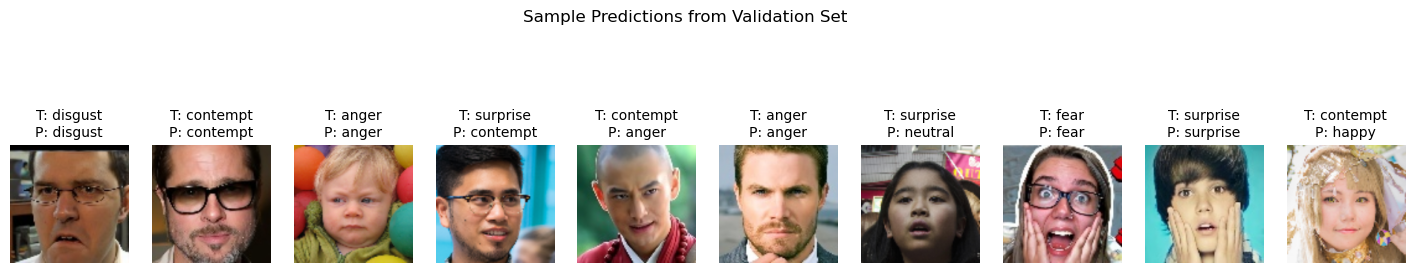

In [56]:
def show_val_predictions(model, X, y_true, label_encoder, num_samples=10):
    """Show sample images from validation set with true and predicted labels."""
    idxs = np.random.choice(len(X), size=num_samples, replace=False)
    y_pred = np.argmax(model.predict(X[idxs]), axis=1)
    plt.figure(figsize=(18, 4))
    for i, idx in enumerate(idxs):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow((X[idx] + 1) / 2)
        true_lbl = label_encoder.classes_[y_true[idx]]
        pred_lbl = label_encoder.classes_[y_pred[i]]
        plt.title(f"T: {true_lbl}\nP: {pred_lbl}", fontsize=10)
        plt.axis('off')
    plt.suptitle("Sample Predictions from Validation Set")
    plt.show()

show_val_predictions(model, X_test, y_te_enc, le, num_samples=10)
